<a href="https://colab.research.google.com/github/yvt-h/SCA_SOP/blob/main/SCA_HW4_SOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales and Operations Planning

Sales and operations planning is an iterative process, where sales and operations plan is updated periodically (every 2 weeks or monthly), based on the updated demand information. In this assignment you will work through that process and see how much forecast updates affect costs.

## Question 1


1. Suppose you are in the month of December. Start with the notebook https://github.com/nosadchiy/public/blob/main/SOP_Green_Apple.ipynbLinks to an external site., solve it and record the total cost breakdown by month from January to June.

In [ ]:
# Install and import packages
!pip install tabulate
!pip install gurobipy
import numpy as np
from gurobipy import Model, GRB, quicksum
from tabulate import tabulate
import matplotlib.pyplot as plt

In [ ]:
### User defined variables
promote = 0
month = 4
base_price = 40
promotion_price = base_price - 1
consumption = 0.10
forward_buy = 0.20

F = np.array([0, 1600, 3000, 3200, 3800, 2200, 2200])

### Variables based on input
n_months = len(F)-1
F = np.append(F, [0, 0])

In [ ]:
def plot_inventory():
  t_values = list(range(1, n_months + 1))

  plt.plot(t_values, [I[t].x for t in t_values], marker='o', label='Inventory')
  plt.plot(t_values, [P[t].x for t in t_values], marker='s', label='Production')
  plt.plot(t_values, [D[t].x for t in t_values], marker='D', label='Demand')
  plt.plot(t_values, [S[t].x for t in t_values], marker='^', label='Stockout')
  plt.plot(t_values, [C[t].x for t in t_values], marker='x', label='Subcontracting')

  # Adding labels and legend
  plt.xlabel('Period')
  plt.ylabel('')
  plt.legend(loc='best')
  plt.title('Aggregate Plan')
  plt.grid(axis='y')

  # Show the plot
  plt.show()

Restricted license - for non-production use only - expires 2025-11-24
+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
| Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price |
|    (t) |   (H) |      (L) |       (W) |      (O) |       (O) |      (S) |         (C) |        (P) |    (D) |  (Pr) |
+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
|      0 |  -0.0 |     -0.0 |      80.0 |     -0.0 |    1000.0 |      0.0 |        -0.0 |       -0.0 |   -0.0 |   nan |
|      1 |   0.0 |     16.0 |      64.0 |     -0.0 |    1960.0 |     -0.0 |        -0.0 |     2560.0 | 1600.0 |  40.0 |
|      2 |   0.0 |     -0.0 |      64.0 |     -0.0 |    1520.0 |     -0.0 |         0.0 |     2560.0 | 3000.0 |  40.0 |
|      3 |   0.0 |     -0.0 |      64.0 |     -0.0 |     880.0 |     -0.0 |         0.0 | 

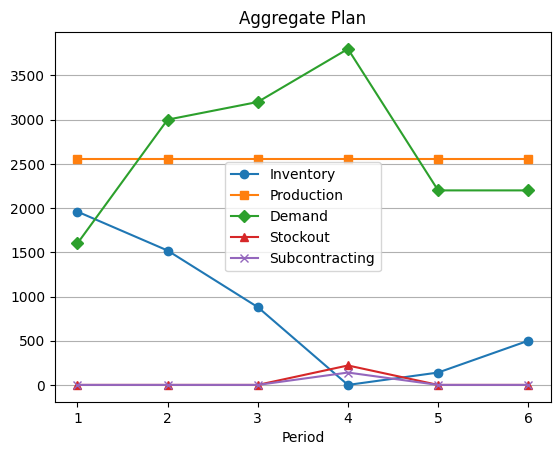

In [ ]:
# Create a Gurobi model
model = Model("MinimizeCost")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

# Store result in table format and print
opt_results = [[t] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] + [P[t].x] + [D[t].x] + [Pr[t]] for t in range(0, n_months + 1)]

headers = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Workforce\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Production\n(P)"] + ["Demand\n(D)"] + ["Price\n(Pr)"]
print(tabulate(opt_results, headers=headers, tablefmt="pretty", stralign="right"))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")

plot_inventory()


In [ ]:
month_names = ["January", "February", "March", "April", "May", "June"]

# Calculate cost for each month
cost_per_month = [300 * H[t].x + 500 * L[t].x + 640 * W[t].x + 6 * O[t].x + 2 * I[t].x + 5 * S[t].x + 30 * C[t].x + 10 * P[t].x for t in range(1, n_months + 1)]

# Print cost for each month with month names
for t, cost in enumerate(cost_per_month, start=1):
    print(f"Cost for {month_names[t-1]}: $ {cost:,.2f}")

Cost for January: $ 78,480.00
Cost for February: $ 69,600.00
Cost for March: $ 68,320.00
Cost for April: $ 71,860.00
Cost for May: $ 66,840.00
Cost for June: $ 67,560.00


## Question 2 - 4

2. One month has passed and you are in the end of January. It turned out that demand in January was a bit slower 1500 units, instead of 1600.  Also your forecasting team projects that demand in April is going to be 3900. They also added demand in July to be 1100.

3. What impact did the change of demand in January have on costs incurred in January, compared to the planned costs computed in Step 1? Assume that January production went according to the plan developed in December.

The equation for calculating the cost is:

```
300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t]
```
This equation represents the total cost, which includes various components such as labor costs (H[t] and L[t]), workforce costs (W[t]), overtime costs (O[t]), inventory costs (I[t]), stockout costs (S[t]), subcontracting costs (C[t]), and production costs (P[t]).

The demand change from 1600 to 1500 units in January only affects the inventory (I[t]) variable in the model, increasing by 100 units. Therefore, the actual cost in January is $2*100=200 greater than the predicted cost.


4. Obtain the updated sales and operations plan for the months of February through July, while accounting for the realized demand in January (and hence the extra inventory) and updated forecasts for April and July. Compare it with the original plan from Step 1 (show the graph for the updated plan). What is the cost difference between the plans for the months Feb through June?

In [ ]:
### User defined variables
promote = 0
month = 5
base_price = 40
promotion_price = base_price - 1
consumption = 0.10
forward_buy = 0.20

F = np.array([0, 3000, 3200, 3900, 2200, 2200, 1100])

### Variables based on input
n_months = len(F)-1
F = np.append(F, [0, 0])

+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
| Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price |
|    (t) |   (H) |      (L) |       (W) |      (O) |       (O) |      (S) |         (C) |        (P) |    (D) |  (Pr) |
+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
|      0 |   0.0 |      0.0 |      64.0 |      0.0 |    2060.0 |      0.0 |         0.0 |        0.0 |    0.0 |   nan |
|      1 |   0.0 |      0.0 |      64.0 |      0.0 |    1620.0 |      0.0 |         0.0 |     2560.0 | 3000.0 |  40.0 |
|      2 |   0.0 |      0.0 |      64.0 |      0.0 |     980.0 |      0.0 |         0.0 |     2560.0 | 3200.0 |  40.0 |
|      3 |   0.0 |      0.0 |      64.0 |      0.0 |       0.0 |      0.0 |       360.0 |     2560.0 | 3900.0 |  40.0 |
|      4 |   0.0 |     10.0 |      54.0 

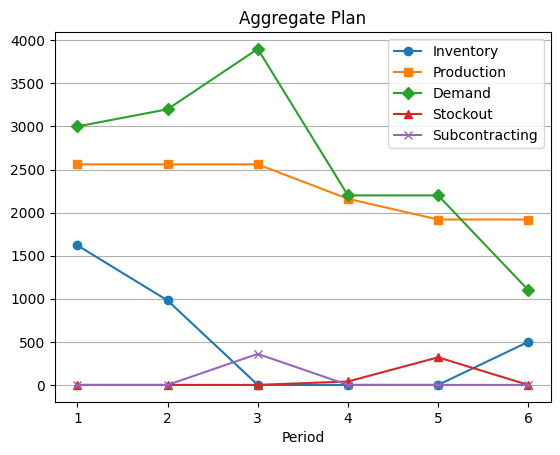

In [ ]:
# Create a Gurobi model
model = Model("MinimizeCost")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 64, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 2060, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

# Store result in table format and print
opt_results = [[t] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] + [P[t].x] + [D[t].x] + [Pr[t]] for t in range(0, n_months + 1)]

headers = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Workforce\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Production\n(P)"] + ["Demand\n(D)"] + ["Price\n(Pr)"]
print(tabulate(opt_results, headers=headers, tablefmt="pretty", stralign="right"))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")

plot_inventory()

In [ ]:
new_month_names = ["February", "March", "April", "May", "June", "July"]

# Calculate cost for each month
cost_per_month = [300 * H[t].x + 500 * L[t].x + 640 * W[t].x + 6 * O[t].x + 2 * I[t].x + 5 * S[t].x + 30 * C[t].x + 10 * P[t].x for t in range(1, n_months + 1)]

# Print cost for each month with month names
for t, cost in enumerate(cost_per_month, start=1):
    print(f"Cost for {new_month_names[t-1]}: $ {cost:,.2f}")

Cost for February: $ 69,800.00
Cost for March: $ 68,520.00
Cost for April: $ 77,360.00
Cost for May: $ 61,360.00
Cost for June: $ 54,520.00
Cost for July: $ 50,920.00


In [ ]:
# Define the old and new costs
old_costs = {
    "February": 69600.00,
    "March": 68320.00,
    "April": 71860.00,
    "May": 66840.00,
    "June": 67560.00
}

new_costs = {
    "February": 69800.00,
    "March": 68520.00,
    "April": 77360.00,
    "May": 61360.00,
    "June": 54520.00
}

# Calculate cost difference between old and new plans for the months February through June
cost_difference = {}
months = list(new_costs.keys())
for month in months:
    cost_difference[month] = new_costs[month] - old_costs[month]

# Print cost difference for each month
for month, difference in cost_difference.items():
    print(f"Cost difference for {month}: $ {difference:,.2f}")


Cost difference for February: $ 200.00
Cost difference for March: $ 200.00
Cost difference for April: $ 5,500.00
Cost difference for May: $ -5,480.00
Cost difference for June: $ -13,040.00


In [ ]:
# Calculate the sum of cost differences
total_cost_difference = sum(cost_difference.values())

# Print the sum of cost differences
print(f"Total cost difference for the months February through June: $ {total_cost_difference:,.2f}")

Total cost difference for the months February through June: $ -12,620.00
